---------Implementation of David Lee's paper---------

Profile:  [array([1, 0, 3, 4, 2]), array([1, 0, 3, 2, 4]), array([2, 0, 1, 3, 4]), array([2, 3, 4, 0, 1]), array([3, 4, 0, 2, 1]), array([2, 3, 1, 0, 4]), array([2, 1, 0, 4, 3]), array([2, 0, 4, 3, 1]), array([2, 4, 1, 0, 3]), array([1, 2, 0, 4, 3])]

Parametres:
eps = 0.500000; delta = 0.200000; N = 64.377516; gamma = 0.100000

BordaPlusRandom Output:  (4, [8, 6, 12, 12, 18])
Borda Output:  (3, [13, 13, 8, 18, 16])
RegBorda Output:  ([4], [18, 17, 17, 22, 26])

Histograms:
Borda Histogram Tally:  [12, 12, 4, 35, 137]


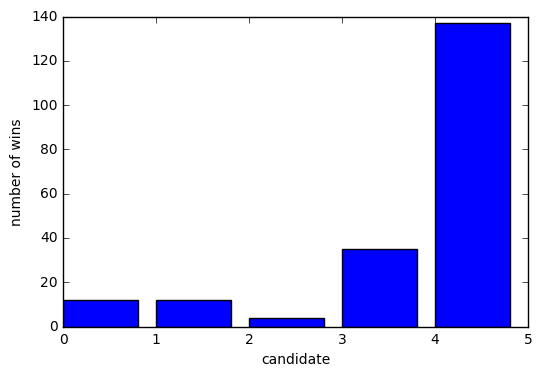

BordaPlusRandomHistogram Tally:  [14, 16, 12, 44, 114]


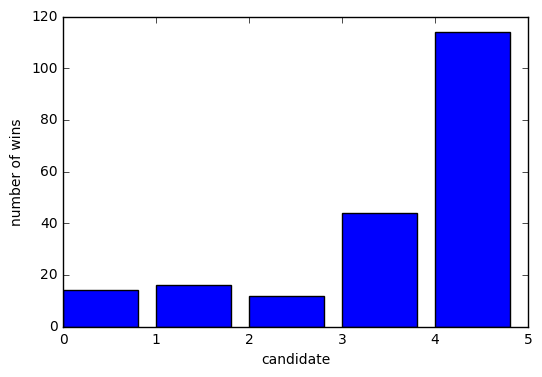

In [1]:
print("---------Implementation of David Lee's paper---------\n")
import random
import numpy
import matplotlib.pyplot as plt
import math

def RegBorda(C,V): #C = #candidates, V = profile, regular Borda with tie breaking uniformly at random
    S = [0] * C
    for x in range(0,C):
        for v in range(0,len(V)):
            S[x] += V[v][x]
    #print("RegBorda Total Score = ", S)
    bestcand = [0]
    for j in range(1, C): 
        if (S[j] > S[bestcand[0]]):
            bestcand = [j]
        elif (S[j] == S[bestcand[0]]):
            bestcand.append(j)       
    return (bestcand, S)
            
def Borda(C,V,N): #C= #candidates, V=profile, N=binomial param
    S = [0] * C
    for x in range(0,C):
        Nx = numpy.random.binomial(N, 2/C)
        for i in range(1,Nx):
            y = x
            while (y == x):
                y = random.randint(0,C - 1)
            v = random.randint(0,len(V) - 1)
            if (V[v][x] > V[v][y]):
                S[x] = S[x] + 1
            #print("Borda: x:%d, y:%d, Vote:%s. S:%s" % (x, y, str(V[v]), str(S)))
    bestcand = [0]
    for j in range(0, C): 
        if (S[j] > S[bestcand[0]]):
            bestcand = [j]
        elif (S[j] == S[bestcand[0]]):
            bestcand.append(j)
    return (random.choice(bestcand), S) #break ties uniformly at random

def BordaPlusRandom(C, V, N, gamma):
    if random.uniform(0,1) <= gamma:
        return (random.choice(range(0,C)),[0]*C) # we make the "Borda score" 0s when we choose winner randomly
    else:
        return Borda(C,V,N)

def BordaHistogram(C, V, N, NumTrials):   
    T = [0] * C  # tally
    for i in range(0,NumTrials):
        T[Borda(C,V,N)[0]] += 1
    print("Borda Histogram Tally: ", T)
    fig = plt.figure()
    plt.bar(numpy.arange(C),T)
    plt.xlabel('candidate')
    plt.ylabel('number of wins')
    plt.show()
    
def BordaPlusRandomHistogram(C, V, N, gamma, NumTrials):   
    T = [0] * C  # tally
    for i in range(0,NumTrials):
        T[BordaPlusRandom(C,V,N,gamma)[0]] += 1
    print("BordaPlusRandomHistogram Tally: ", T)
    fig = plt.figure()
    plt.bar(numpy.arange(C),T)
    plt.xlabel('candidate')
    plt.ylabel('number of wins')
    plt.show()

def GenRandProfile(C, NumVotes):
    V = []
    toPermute = numpy.arange(C)
    for i in range(0,NumVotes):
        V.append(numpy.random.permutation(toPermute))
    return V



C = 5
NumVotes = 10
eps = 0.5 # eps => eps-differential privacy
delta = 0.2 # we find a eps-Borda winner w/prob 1-delta
N = C/(eps ** 2) * math.log(C/delta) 
gamma = min(0.5 * delta, 1/C)
NumTrials = 200;

V = GenRandProfile(C,NumVotes)
print("Profile: ", V)

print("\nParametres:")
print("eps = %f; delta = %f; N = %f; gamma = %f\n" % (eps, delta, N, gamma))


print("BordaPlusRandom Output: ", BordaPlusRandom(C,V,N,gamma))
print("Borda Output: ", Borda(C,V,N))
print("RegBorda Output: ", RegBorda(C,V))


print("\nHistograms:")
BordaHistogram(C,V,N,NumTrials)
BordaPlusRandomHistogram(C,V,N,gamma,NumTrials)

---------Implementation of Borda+Laplace---------

RegBorda results:  ([0], [411, 387, 406, 388, 408])
Borda+Laplace result:  (4, [353.25069677065727, 324.38487680288557, 408.99828301196794, 373.77910795677286, 475.68091833371381])
BordaPlusRandomHistogram Tally:  [122, 69, 121, 70, 118]


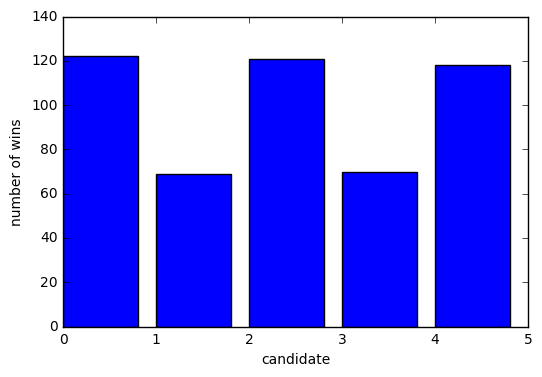

Borda+Laplace Tally:  [153, 50, 128, 55, 114]


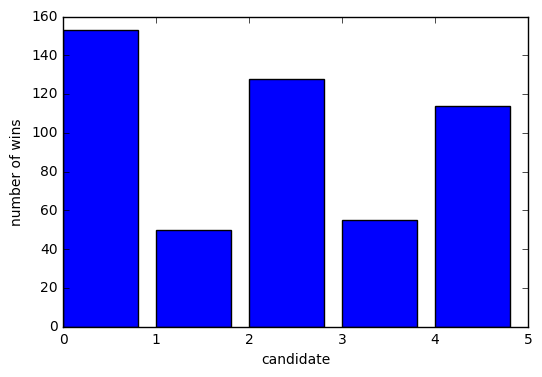

In [2]:
print("---------Implementation of Borda+Laplace---------\n")
import itertools
def L1Norm(V1, V2):
    sum = 0
    for i in range(0, max(len(V1), len(V2))):
        sum += abs(V1[i] - V2[i])
    return sum

def BordaGS(C): # the sensitivity of function outputting tuple of Borda scores of all candidates
                # this uses the definition of neighbour where |D1| = |D2|
    maxnorm = 0
    for p in itertools.permutations(range(C)):
        #print(p, " ", L1Norm(p, range(C)))
        if (L1Norm(p, range(C)) > maxnorm):
            maxnorm = L1Norm(p, range(C))
    return maxnorm

def BordaLap(C, V, eps): # returns the Borda scores plus Laplacian noise, and the winner with noised scores
    sensitivity = BordaGS(C)
    #print("Laplace scale: sensitivity/eps = ", sensitivity/eps)
    (RegWinner, RegScores) = RegBorda(C,V)
    #print(RegWinner, RegScores)
    NoisyScores = RegScores
    for i in range(len(NoisyScores)):
        NoisyScores[i] += numpy.random.laplace(0, sensitivity/eps)
    bestcand = [0]
    for j in range(0, C): 
        if (NoisyScores[j] > NoisyScores[bestcand[0]]):
            bestcand = [j]
        elif (NoisyScores[j] == NoisyScores[bestcand[0]]):
            bestcand.append(j)       
    return (random.choice(bestcand), NoisyScores)

def BordaLapHistogram(C, V, eps, NumTrials):   
    T = [0] * C  # tally
    for i in range(0,NumTrials):
        T[BordaLap(C,V,eps)[0]] += 1
    print("Borda+Laplace Tally: ", T)
    fig = plt.figure()
    plt.bar(numpy.arange(C),T)
    plt.xlabel('candidate')
    plt.ylabel('number of wins')
    plt.show()    
    
C = 5
V = GenRandProfile(C, 200)
eps = 0.5
delta = 0.2 # we find a eps-Borda winner w/prob 1-delta
N = C/(eps ** 2) * math.log(C/delta) 
gamma = min(0.5 * delta, 1/C)
NumTrials = 500;

print("RegBorda results: ", RegBorda(C,V))
print("Borda+Laplace result: ", BordaLap(C,V,eps))

BordaPlusRandomHistogram(C,V,N,gamma,NumTrials)

BordaLapHistogram(C,V,eps, NumTrials)


In [3]:
print("---------Paillier for Vote Aggregation (Implementation from Github)---------")
print("---------https://github.com/mikeivanov/paillier---------\n")

from paillier.paillier import * # https://github.com/mikeivanov/paillier
import numpy
priv, pub = generate_keypair(128)

def GenRandProfilePaillier(C, NumVotes):
    V = []
    toPermute = numpy.arange(C)
    for i in range(0,NumVotes):
        vote = numpy.random.permutation(toPermute)
        print(vote)
        encvote = []
        for j in vote:
            encvote.append(encrypt(pub, j))
        V.append(encvote)
    return V

def DecryptProfilePaillier(V):
    DecV = []
    for encvote in V:
        vote = []
        for j in encvote:
            vote.append(decrypt(priv, pub, j))
        DecV.append(vote)
    return DecV

def TallyPaillier(C, V):
    T = [encrypt(pub,0)]*C
    for vote in V:
        for i in range(C):
            #print(vote[i])
            #print(e_add(pub, T[i], vote[i]))
            T[i] = e_add(pub, T[i], vote[i])
    return T


def DecryptTallyPaillier(T):
    DecT = [0] * len(T)
    for i in range(len(T)):
        DecT[i] = decrypt(priv, pub, T[i]) 
    return DecT

C = 3
NumVotes = 2
V = GenRandProfilePaillier(C, NumVotes)
print("Encrypted Votes: ", V)
T = TallyPaillier(C, V)
print("Tally of Encrypted Votes: ", T)
DecT = DecryptTallyPaillier(T)
print("Decryption of Tally: ", DecT)


---------Paillier for Vote Aggregation (Implementation from Github)---------
---------https://github.com/mikeivanov/paillier---------

[2 1 0]
[1 0 2]
Encrypted Votes:  [[8675557389459623714073136113131553815869612127983485147989043521292873037134, 127961128422009934117103219321345846206251198515967811879548841268692836179, 19414770120973401372586291215545196203083033181872967038992618214700426723172], [7448727065706454956079429214048693344651621670599090719543721919551705282867, 13055937454573306689685820625969184395236508681642097992911053802035669818495, 23028050203077479193322102098053858036357860269105145242019168261049753425086]]
Tally of Encrypted Votes:  [25161942885346543766892447140997804936080539594347920074688439388291492122494, 5275033072864585089536762376031189596554357395697519902131497211656111102653, 9218937596879680775131879878217245118979709272506279834832799399313103893415]
Decryption of Tally:  [3, 1, 2]


---------Exponential Mechanism v1 and v2---------
---------with comparisons to Lee's paper and Borda+Laplace---------

RegBorda results:  ([0], [211, 182, 207])
Borda+Laplace result:  (0, [213.68957365935736, 198.72481651207082, 211.0468672145083])
[211, 182, 207]
Utility of candidate  0 :  -178
Utility of candidate  1 :  -236
Utility of candidate  2 :  -186
The sensitivity of utility function with  3  candidates:  3.0
[211, 182, 207]
Utility2 of candidate  0 :  16.5
Utility2 of candidate  1 :  -27.0
Utility2 of candidate  2 :  10.5
The sensitivity of utility function #2 with  3  candidates:  1.5
ProbList for utility ver 1:  [0.6572992484230864, 0.0052320651092446907, 0.33746868646766887]
ProbList for utility ver 2:  [0.730679225262579, 0.00051890967224080156, 0.26880186506518017]
BordaPlusRandomHistogram Tally:  [840, 422, 738]


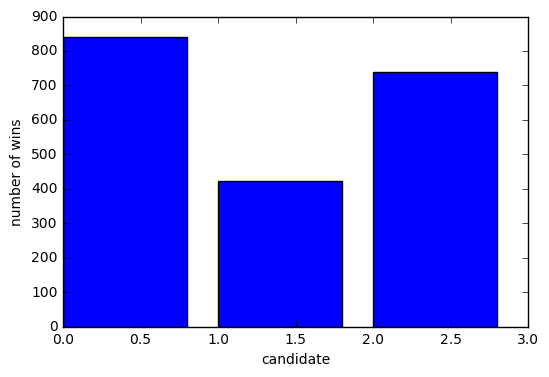

Borda+Laplace Tally:  [1233, 31, 736]


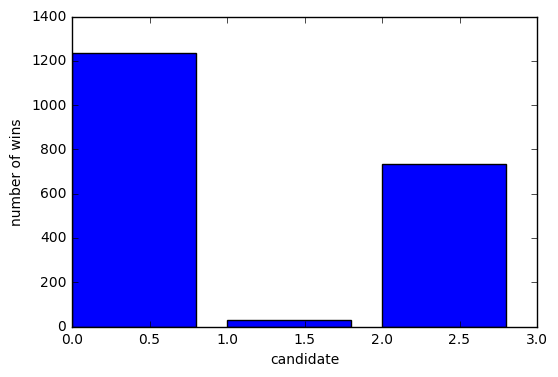

In [4]:
print("---------Exponential Mechanism v1 and v2---------")
print("---------with comparisons to Lee's paper and Borda+Laplace---------\n")

import numpy
import math

def BordaScore(C,V): # C = #candidates, V = profile, regular Borda with tie breaking uniformly at random
    S = [0] * C
    for x in range(0,C):
        for v in range(0,len(V)):
            S[x] += V[v][x]  
    return S

def duBorda(C):
    return (C-1)*C/2

def du2Borda(C): # the second definition of utility
    return C/2

def uBorda(C, V, r): # C = #candidates, V = profile, r \in {0,...C-1} is the winning candidate
    S = BordaScore(C, V)
    pr = [0]* C # proxy for r = [0,..., 1, 0, ....] where the "1" is at the rth position
    pr[r] = 1
    
    util = numpy.dot(S, pr)
    for other in range(0, C):
        if (other != r):
            pother = [0] * C
            pother[other] = 1
            util -= numpy.dot(S, pother)
    return util

def u2Borda(C, V, r): # C = #candidates, V = profile, r \in {0,...C-1} is the winning candidate
    S = BordaScore(C, V)
    pr = [0]* C # proxy for r = [0,..., 1, 0, ....] where the "1" is at the rth position
    pr[r] = 1
    
    util = numpy.dot(S, pr)
    for other in range(0, C):
        if (other != r):
            pother = [0] * C
            pother[other] = 1
            util -= 1/(C-1) * numpy.dot(S, pother)
    return util

def ProbList(eps, du, C, V):
    k = math.exp(eps/(2*du)) # Pr[r wins | V] ~ k^(u(V,r))
    normfactor = 0
    for r in range(0, C):
        normfactor += k**uBorda(C,V,r)
    plist = [0] * C
    for r in range(0,C):
        plist[r] = k**uBorda(C,V,r) / normfactor
    return plist
    
def ProbList2(eps, du, C, V):
    k = math.exp(eps/(2*du)) # Pr[r wins | V] ~ k^(u(V,r))
    normfactor = 0
    for r in range(0, C):
        normfactor += k**u2Borda(C,V,r)
    plist = [0] * C
    for r in range(0,C):
        plist[r] = k**u2Borda(C,V,r) / normfactor
    return plist

def GenRandProfile(C, NumVotes):
    V = []
    toPermute = numpy.arange(C)
    for i in range(0,NumVotes):
        V.append(numpy.random.permutation(toPermute))
    return V

C = 3
V = GenRandProfile(C, 200)
eps = 0.5
delta = 0.2 # we find a eps-Borda winner w/prob 1-delta
N = C/(eps ** 2) * math.log(C/delta) 
gamma = min(0.5 * delta, 1/C)
NumTrials = 2000;

print("RegBorda results: ", RegBorda(C,V))
print("Borda+Laplace result: ", BordaLap(C,V,eps))




#First version of the utility = f(P)*pr - sum(f(P)*pr')
print(BordaScore(C, V))
for r in range(0, C):
    print("Utility of candidate ", r, ": ", uBorda(C, V, r))
print("The sensitivity of utility function with ", C, " candidates: ", duBorda(C))


#Second version of the utility = f(P)*pr - 1/(C-1) * sum(f(P)*pr')
print(BordaScore(C, V))
for r in range(0, C):
    print("Utility2 of candidate ", r, ": ", u2Borda(C, V, r))
print("The sensitivity of utility function #2 with ", C, " candidates: ", du2Borda(C))


print("ProbList for utility ver 1: ", ProbList(eps, duBorda(C), C, V))
print("ProbList for utility ver 2: ", ProbList2(eps, du2Borda(C), C, V))


BordaPlusRandomHistogram(C,V,N,gamma,NumTrials)

BordaLapHistogram(C,V,eps, NumTrials)


In [7]:
print("---------Comparative accuracy of different methods---------")
print("---------(Uniformly Generated Profiles)---------")
print("---------(Change parametres for different accuracies)---------\n")

import matplotlib.pyplot as plt

def AccuracyExperiment(C, eps, NumTrials, NumVotes):
    #Params for Borda+Random
    delta = 0.2 # we find a eps-Borda winner w/prob 1-delta
    N = C/(eps ** 2) * math.log(C/delta) 
    gamma = min(0.5 * delta, 1/C)
    
    NumMechanisms = 4 #(0) - BordaPlusRandom(Lee's Paper), (1) - Borda+Laplace, Exponential Mechanism (2) - v1 and (3) - v2
    #Tallies for each mechanism
    #one tally for every time a mechanism's chosen winner is in the set of best candidates
    #for deterministic Borda
    Tallies = [0] * NumMechanisms

    for i in range(0, NumTrials):
        V = GenRandProfile(C, NumVotes)
        bestcands = RegBorda(C,V)[0] # RegBorda = "real result", we count all candidates with max Borda score
        #print(bestcands)
        BordaPlusRandomWinner = BordaPlusRandom(C, V, N, gamma)[0]
        BordaLapWinner = BordaLap(C,V,eps)[0]
        ExpMechWinner = numpy.random.choice(numpy.arange(0, C), p=ProbList(eps, duBorda(C), C, V))
        ExpMech2Winner = numpy.random.choice(numpy.arange(0, C), p=ProbList2(eps, du2Borda(C), C, V))
        #print("BordaPlusRandomWinner: ", BordaPlusRandomWinner)
        #print("BordaLapWinner: ", BordaLapWinner)
        #print("ExpMechWinner: ", ExpMechWinner)
        #print("ExpMech2Winner: ", ExpMech2Winner)
        if(BordaPlusRandomWinner in bestcands): 
            Tallies[0]+=1
        if(BordaLapWinner in bestcands):
            Tallies[1]+=1
        if(ExpMechWinner in bestcands): 
            Tallies[2]+=1
        if(ExpMech2Winner in bestcands):
            Tallies[3]+=1  
    return Tallies

#Params to mechanisms
C = 3
eps = 0.1

#Params to experiment
NumTrials = 200 
NumVotes = 200 # shang's simulations used 1000~100,000 votes....my computer can't handle this :(


Tallies = AccuracyExperiment(C, eps, NumTrials, NumVotes)

print("\nParametres:")
print("General params: eps = %f; number of candidates = %d; number of votes = %d; number of trials = %d" %(eps, C, NumVotes, NumTrials))
print("Params for Lee's paper: delta = %f; N = %f; gamma = %f\n" % (delta, N, gamma)) 
print("Number of correct choice of winner, out of ", NumTrials, ": ", Tallies)
print("Accuracy for random profiles: ", numpy.divide(Tallies, NumTrials))


print("\nAccuracy with respect to eps")
#Generate a list of epsilons
epsilons = numpy.arange(0.1, 2.1, 0.1)
print("Epsilons: ", epsilons)

#Generate a list of experiment results for each epsilon
T = [AccuracyExperiment(C, epsilons[0], NumTrials, NumVotes)]
for i in range(1, len(epsilons)):
     T.append(AccuracyExperiment(C, epsilons[i], NumTrials, NumVotes))
print(T)


---------Comparative accuracy of different methods---------
---------(Uniformly Generated Profiles)---------
---------(Change parametres for different accuracies)---------


Parametres:
General params: eps = 0.100000; number of candidates = 3; number of votes = 200; number of trials = 200
Params for Lee's paper: delta = 0.200000; N = 32.496602; gamma = 0.100000

Number of correct choice of winner, out of  200 :  [138, 105, 99, 114]
Accuracy for random profiles:  [ 0.69   0.525  0.495  0.57 ]

Accuracy with respect to eps
Epsilons:  [ 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3  1.4  1.5
  1.6  1.7  1.8  1.9  2. ]
[[130, 95, 100, 119], [105, 117, 105, 138], [107, 134, 134, 145], [102, 141, 153, 161], [91, 151, 158, 174], [82, 144, 157, 175], [76, 161, 166, 174], [78, 165, 169, 178], [90, 168, 176, 190], [87, 170, 178, 187], [74, 174, 181, 188], [71, 175, 172, 186], [73, 184, 185, 193], [74, 179, 186, 193], [77, 179, 188, 193], [66, 177, 189, 194], [72, 174, 185, 192]

---------Graphs of Accuracy vs Epsilon values---------

Tallies for Borda+Random:  [130, 105, 107, 102, 91, 82, 76, 78, 90, 87, 74, 71, 73, 74, 77, 66, 72, 73, 72, 73]  out of:  200
Tallies for Borda+Laplace:  [95, 117, 134, 141, 151, 144, 161, 165, 168, 170, 174, 175, 184, 179, 179, 177, 174, 181, 181, 182]
Tallies for Exponential Mechanism V1:  [100, 105, 134, 153, 158, 157, 166, 169, 176, 178, 181, 172, 185, 186, 188, 189, 185, 189, 192, 194]
Tallies for Exponential Mechanism V2:  [119, 138, 145, 161, 174, 175, 174, 178, 190, 187, 188, 186, 193, 193, 193, 194, 192, 195, 197, 196]
The accuracy of Lee's paper goes down as epsilon gets bigger. Odd!


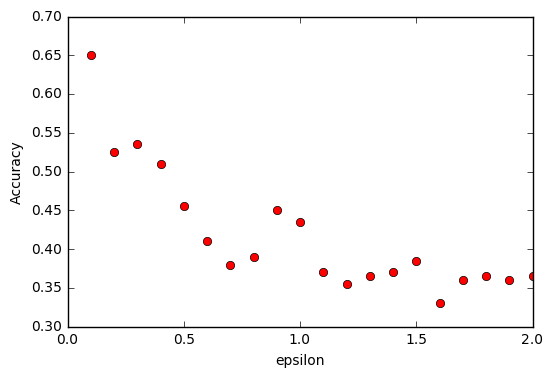

Accuracy of Borda+Laplace


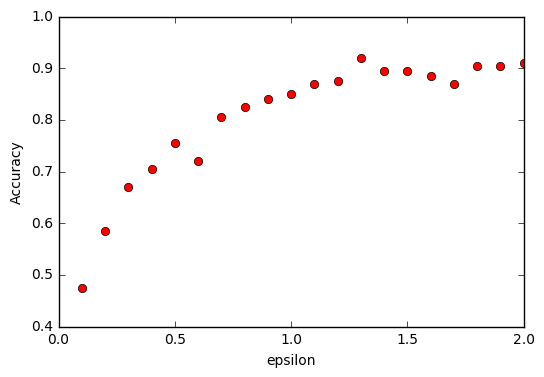

Accuracy of Exponential Mechanism V1


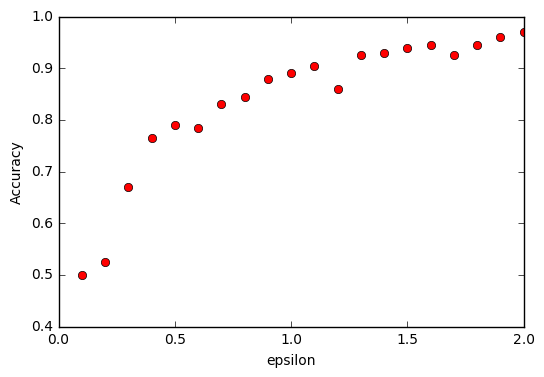

Accuracy of Exponential Mechanism V2


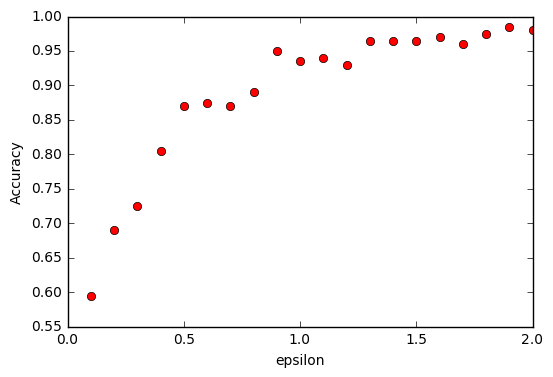

In [8]:
print("---------Graphs of Accuracy vs Epsilon values---------\n")
        
#Tallies for Borda+Random
T0 = [T[0][0]]
for i in range(1, len(epsilons)):
    T0.append(T[i][0])
print("Tallies for Borda+Random: ", T0, " out of: ", NumTrials)

#Tallies for Borda+Laplace
T1 = [T[0][1]]
for i in range(1, len(epsilons)):
    T1.append(T[i][1])
print("Tallies for Borda+Laplace: ", T1)

#Tallies for ExpMech1
T2 = [T[0][2]]
for i in range(1, len(epsilons)):
    T2.append(T[i][2])
print("Tallies for Exponential Mechanism V1: ", T2)

#Tallies for ExpMech2
T3 = [T[0][3]]
for i in range(1, len(epsilons)):
    T3.append(T[i][3])
print("Tallies for Exponential Mechanism V2: ", T3)

print("The accuracy of Lee's paper goes down as epsilon gets bigger. Odd!")
plt.plot(epsilons, numpy.divide(T0, NumTrials), 'ro')
plt.ylabel('Accuracy')
plt.xlabel('epsilon')
plt.show()

print("Accuracy of Borda+Laplace")
plt.plot(epsilons, numpy.divide(T1, NumTrials), 'ro')
plt.ylabel('Accuracy')
plt.xlabel('epsilon')
plt.show()


print("Accuracy of Exponential Mechanism V1")
plt.plot(epsilons, numpy.divide(T2, NumTrials), 'ro')
plt.ylabel('Accuracy')
plt.xlabel('epsilon')
plt.show()

print("Accuracy of Exponential Mechanism V2")
plt.plot(epsilons, numpy.divide(T3, NumTrials), 'ro')
plt.ylabel('Accuracy')
plt.xlabel('epsilon')
plt.show()
